### <b> PySpark vs GCP </b>

#### <b> PySpark </b>

In [36]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, when, datediff, hour, minute, count
import os
import time
import matplotlib.pyplot as plt

In [37]:
import psutil

# Print your system's available memory
mem_info = psutil.virtual_memory()
print(f"Total memory: {mem_info.total / (1024**3):.2f} GB")
print(f"Available memory: {mem_info.available / (1024**3):.2f} GB")

Total memory: 18.00 GB
Available memory: 7.48 GB


* <b> Java is required: </b> brew install openjdk@11 (MacOs) OR sudo apt install openjdk-11-jdk (Ubuntu)


#### <b> Spark and CSV data loading functions </b>

In [38]:
# spark.driver.memory: Used by the main program that orchestrates tasks (Stores task results, coordinates actions, loads final DataFrames)
# spark.executor.memory: Used by worker processes that execute individual tasks (Data processing, transformations, aggregations, shuffling)
# spark.driver.maxResultSize: limits the total size of serialized results that can be returned to the driver from all partitions in a single Spark operation
def initialize_spark():
    '''
    Description: Initialize Spark Session

    Arguments: 
        -None
    Output: 
        -Spark session
    '''
    spark = SparkSession.builder \
                        .appName("MIMIC-III LOS Prediction") \
                        .config("spark.driver.memory", "12g") \
                        .config("spark.executor.memory", "12g") \
                        .config("spark.driver.maxResultSize", "6g") \
                        .getOrCreate()

    # Check initialization
    print("Success! Spark is working.")
    print(f"Spark version: {spark.version}\n")

    return spark

def load_csv_table(spark, csv_dir, table_name):
    """Load a CSV table with performance timing."""
    csv_path = os.path.join(csv_dir, f"{table_name.upper()}.csv")
    
    print(f"Loading {table_name} from CSV...")
    start_time = time.time()
    
    
    df = spark.read.csv(csv_path, header=True, inferSchema=True)
    df = df.drop("ROW_ID")
    
    # Force action to measure full load time
    count = df.count()
    end_time = time.time()
    
    print(f"Loaded {table_name}: {count} rows in {end_time - start_time:.2f} seconds")
    return df

In [39]:
spark = initialize_spark()

init_time = time.time()

# Load tables
admissions_df = load_csv_table(spark, "../data/raw", "admissions")
print("\n")
callout_df = load_csv_table(spark, "../data/raw", "callout")
print("\n")
chart_events_df = load_csv_table(spark, "../data/raw", "chartevents")
print("\n")
d_icd_diagnoses = load_csv_table(spark, "../data/raw", "d_icd_diagnoses")
print("\n")
d_items_df = load_csv_table(spark, "../data/raw", "d_items")
print("\n")
diagnoses_icd_df = load_csv_table(spark, "../data/raw", "diagnoses_icd")
print("\n")
icustays_df = load_csv_table(spark, "../data/raw", "icustays")
print("\n")
patients_df = load_csv_table(spark, "../data/raw", "patients")
print("\n")
services_df = load_csv_table(spark, "../data/raw", "services")
print("\n")

final_time = time.time() - init_time

print(f"Total loading time: {final_time}")

Success! Spark is working.
Spark version: 3.5.5

Loading admissions from CSV...
Loaded admissions: 58976 rows in 0.31 seconds


Loading callout from CSV...
Loaded callout: 34499 rows in 0.20 seconds


Loading chartevents from CSV...


Loaded chartevents: 330712483 rows in 94.00 seconds


Loading d_icd_diagnoses from CSV...
Loaded d_icd_diagnoses: 14567 rows in 0.09 seconds


Loading d_items from CSV...
Loaded d_items: 12487 rows in 0.08 seconds


Loading diagnoses_icd from CSV...
Loaded diagnoses_icd: 651047 rows in 0.27 seconds


Loading icustays from CSV...
Loaded icustays: 61532 rows in 0.15 seconds


Loading patients from CSV...
Loaded patients: 46520 rows in 0.13 seconds


Loading services from CSV...
Loaded services: 73343 rows in 0.16 seconds


Total loading time: 95.39649295806885


In [40]:
chart_events_df.show(5)

+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|        36| 165660|    241249|223834|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|   15|    15.0|   L/min|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|223835|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|  100|   100.0|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224328|2134-05-12 12:00:00|2134-05-12 12:18:00|20823|  .37|    0.37|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224329|2134-05-12 12:00:00|2134-05-12 12:19:00|20823|    6|     6.0|     min|      0|    0|        NULL| 

#### <b> Join tables based on the MIMIC-III dataset structure</b>

* 1 patient can have multiple ICU stays and Admissions
* We can extract total Hospital LOS by subtracting DISCHTIME to ADMITTIME
* We also can extract total ICU LOS

In [41]:
# Let's examine the multiple ICU stays situation
def analyze_multiple_icu_stays(icustays_df):
    """
    Analyze patterns of multiple ICU stays in the dataset.
    """
    print("=== Analysis of Multiple ICU Stays ===")
    
    # Total ICU stays
    total_stays = icustays_df.count()
    print(f"Total ICU stays: {total_stays}")
    
    # Unique patients
    unique_patients = icustays_df.select("SUBJECT_ID").distinct().count()
    print(f"Unique patients: {unique_patients}")
    
    # Unique hospital admissions
    unique_admissions = icustays_df.select("HADM_ID").distinct().count()
    print(f"Unique hospital admissions: {unique_admissions}")
    
    # Patients with multiple ICU stays (any combination)
    patients_multiple_stays = icustays_df.groupBy("SUBJECT_ID") \
        .agg(count("ICUSTAY_ID").alias("icu_stays_count")) \
        .filter("icu_stays_count > 1")
    
    multiple_stays_count = patients_multiple_stays.count()
    print(f"Patients with multiple ICU stays: {multiple_stays_count}")
    
    # Distribution of ICU stays per patient
    print("\nDistribution of ICU stays per patient:")
    icustays_df.groupBy("SUBJECT_ID") \
        .agg(count("ICUSTAY_ID").alias("stays_count")) \
        .groupBy("stays_count") \
        .agg(count("SUBJECT_ID").alias("patient_count")) \
        .orderBy("stays_count") \
        .show()
    
    
    # Multiple ICU stays within same hospital admission
    same_admission_multiple = icustays_df.groupBy("HADM_ID") \
        .agg(count("ICUSTAY_ID").alias("icu_stays_in_admission")) \
        .filter("icu_stays_in_admission > 1")
    
    same_admission_count = same_admission_multiple.count()
    print(f"Hospital admissions with multiple ICU stays: {same_admission_count}")
    
    # Show examples
    print("\nExamples of patients with multiple ICU stays:")
    icustays_df.join(patients_multiple_stays.limit(3), "SUBJECT_ID") \
        .select("SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "INTIME", "OUTTIME", "LOS") \
        .orderBy("SUBJECT_ID", "INTIME") \
        .show(truncate=False)
    
    return {
        "total_stays": total_stays,
        "unique_patients": unique_patients,
        "patients_with_multiple_stays": multiple_stays_count,
        "admissions_with_multiple_icu_stays": same_admission_count
    }



# Run the analysis
stats = analyze_multiple_icu_stays(icustays_df)

=== Analysis of Multiple ICU Stays ===
Total ICU stays: 61532
Unique patients: 46476
Unique hospital admissions: 57786
Patients with multiple ICU stays: 8755

Distribution of ICU stays per patient:
+-----------+-------------+
|stays_count|patient_count|
+-----------+-------------+
|          1|        37721|
|          2|         5796|
|          3|         1619|
|          4|          650|
|          5|          300|
|          6|          151|
|          7|           86|
|          8|           44|
|          9|           29|
|         10|           19|
|         11|           15|
|         12|           11|
|         13|            8|
|         14|            4|
|         15|            6|
|         16|            2|
|         17|            2|
|         18|            2|
|         20|            1|
|         21|            2|
+-----------+-------------+
only showing top 20 rows

Hospital admissions with multiple ICU stays: 3260

Examples of patients with multiple ICU stays:
+------

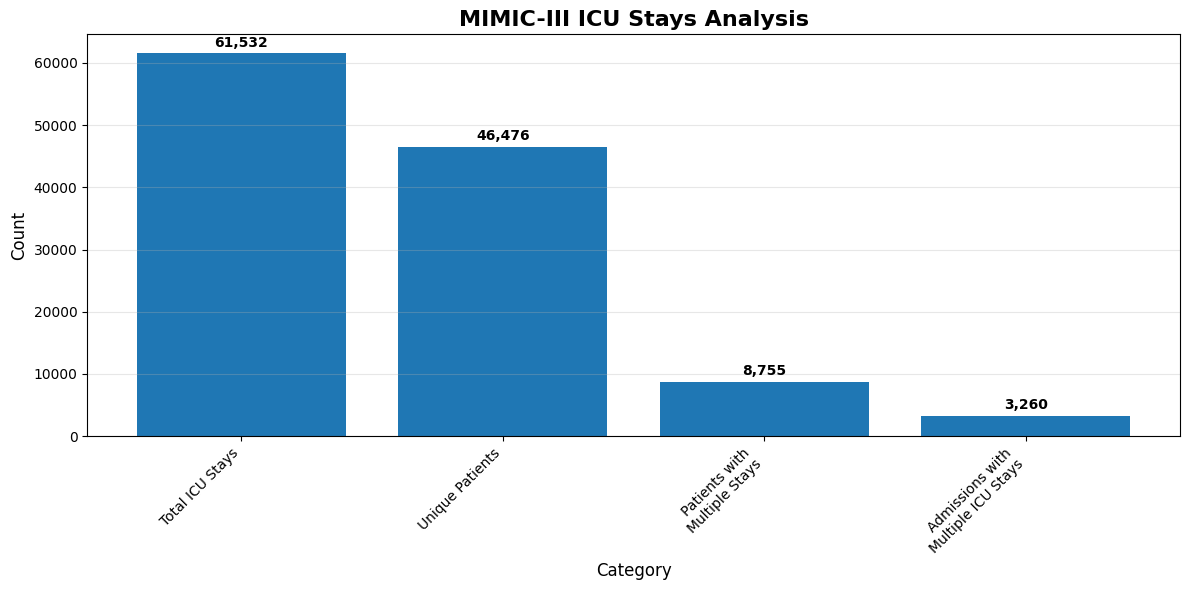

In [43]:
import matplotlib.pyplot as plt

xx = []
total_stays = stats["total_stays"]
xx.append(total_stays)
unique_patients = stats["unique_patients"]
xx.append(unique_patients)
patients_with_multiple_stays = stats["patients_with_multiple_stays"]
xx.append(patients_with_multiple_stays)
admissions_with_multiple_icu_stays = stats["admissions_with_multiple_icu_stays"]
xx.append(admissions_with_multiple_icu_stays)

# Create labels for the x-axis
labels = ['Total ICU Stays', 'Unique Patients', 'Patients with\nMultiple Stays', 'Admissions with\nMultiple ICU Stays']

# Create values for the y-axis (your actual data)
values = xx

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values)

# Add value labels on top of each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01, 
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

# Customize the plot
plt.title('MIMIC-III ICU Stays Analysis', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)

# Rotate x-axis labels if needed for better readability
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
plt.grid(axis='y', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [44]:
stats

{'total_stays': 61532,
 'unique_patients': 46476,
 'patients_with_multiple_stays': 8755,
 'admissions_with_multiple_icu_stays': 3260}

Let's join <b> ICUSTAYS and ADMISSIONS </b> table to get relevant information from patients that were admitted to the ICU when they went to the hospital, and exclude those that didn't

In [45]:
new_icustays_df = icustays_df.join(admissions_df, on=["SUBJECT_ID", "HADM_ID"], how="left")

Now we join the <b> complete ICU data with the PATIENTS info </b>

In [46]:
patients_full_info_df = new_icustays_df.join(patients_df, on="SUBJECT_ID", how="left")

In [47]:
columns=["DOD_HOSP", "DOD_SSN"]
patients_full_info_df = patients_full_info_df.drop(*columns) # redundant since DOD column gives us the same info

In [49]:
patients_full_info_df.show(5)

+----------+-------+----------+----------+--------------+-------------+------------+-----------+-------------------+-------------------+------+-------------------+-------------------+-------------------+--------------+--------------------+--------------------+---------+--------+-----------------+--------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+------+-------------------+-------------------+-----------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|  DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|            OUTTIME|   LOS|          ADMITTIME|          DISCHTIME|          DEATHTIME|ADMISSION_TYPE|  ADMISSION_LOCATION|  DISCHARGE_LOCATION|INSURANCE|LANGUAGE|         RELIGION|MARITAL_STATUS|           ETHNICITY|          EDREGTIME|          EDOUTTIME|           DIAGNOSIS|HOSPITAL_EXPIRE_FLAG|HAS_CHARTEVENTS_DATA|GENDER|                DOB|                DOD|EXPIRE_FLAG|
+-------

In [50]:
# Check if row counts are the same
print(f"ICUSTAYS count: {icustays_df.count()}")
print(f"After joining ADMISSIONS: {new_icustays_df.count()}")
print(f"After joining PATIENTS: {patients_full_info_df.count()}")


ICUSTAYS count: 61532
After joining ADMISSIONS: 61532
After joining PATIENTS: 61532


In [51]:
d_icd_diagnoses.show(5)

+---------+--------------------+--------------------+
|ICD9_CODE|         SHORT_TITLE|          LONG_TITLE|
+---------+--------------------+--------------------+
|    01166|TB pneumonia-oth ...|Tuberculous pneum...|
|    01170|TB pneumothorax-u...|Tuberculous pneum...|
|    01171|TB pneumothorax-n...|Tuberculous pneum...|
|    01172|TB pneumothorx-ex...|Tuberculous pneum...|
|    01173|TB pneumothorax-m...|Tuberculous pneum...|
+---------+--------------------+--------------------+
only showing top 5 rows



Join the <b> DIAGNOSES and D_ICD_DIAGNOSES tables </b> to get diagnoses descriptions based on the ICD9 code

In [52]:
full_diagnosis_data = diagnoses_icd_df.join(d_icd_diagnoses, on="ICD9_CODE", how="left")
full_diagnosis_data = full_diagnosis_data.drop("SHORT_TITLE")

In [53]:
p_268 = full_diagnosis_data[full_diagnosis_data["SUBJECT_ID"]==268]

In [54]:
p_268.show() # 1 patient can have multiple diagnoses for the same HADM

+---------+----------+-------+-------+--------------------+
|ICD9_CODE|SUBJECT_ID|HADM_ID|SEQ_NUM|          LONG_TITLE|
+---------+----------+-------+-------+--------------------+
|    48241|       268| 110404|      1|Methicillin susce...|
|     4280|       268| 110404|      2|Congestive heart ...|
|    51881|       268| 110404|      3|Acute respiratory...|
|     5845|       268| 110404|      4|Acute kidney fail...|
|     4275|       268| 110404|      5|      Cardiac arrest|
|     0389|       268| 110404|      6|Unspecified septi...|
|    49322|       268| 110404|      7|Chronic obstructi...|
|     2761|       268| 110404|      8|Hyposmolality and...|
|     4271|       268| 110404|      9|Paroxysmal ventri...|
+---------+----------+-------+-------+--------------------+



In [55]:
yo = p_268[p_268["SEQ_NUM"]==1]

In [56]:
title = yo["LONG_TITLE"]

In [57]:
yo.select("LONG_TITLE").collect()[0][0]

'Methicillin susceptible pneumonia due to Staphylococcus aureus'

In [58]:
yo.select("LONG_TITLE").first()[0]

'Methicillin susceptible pneumonia due to Staphylococcus aureus'

In [59]:
full_diagnosis_data.show(5)

+---------+----------+-------+-------+--------------------+
|ICD9_CODE|SUBJECT_ID|HADM_ID|SEQ_NUM|          LONG_TITLE|
+---------+----------+-------+-------+--------------------+
|    40301|       109| 172335|      1|Hypertensive chro...|
|      486|       109| 172335|      2|Pneumonia, organi...|
|    58281|       109| 172335|      3|Chronic glomerulo...|
|     5855|       109| 172335|      4|Chronic kidney di...|
|     4254|       109| 172335|      5|Other primary car...|
+---------+----------+-------+-------+--------------------+
only showing top 5 rows



Now join <b> PATIENT and DIAGNOSES </b> data

In [60]:
patients_full_info_df = patients_full_info_df.join(full_diagnosis_data, on=["SUBJECT_ID","HADM_ID"], how="left")

In [ ]:
patients_full_info_df.show(5)

+----------+-------+----------+--------+--------------+-------------+------------+-----------+-------------------+-------------------+-----+-------------------+-------------------+-------------------+--------------+--------------------+------------------+---------+--------+--------+--------------+------------------+-------------------+-------------------+---------+--------------------+--------------------+------+-------------------+-------------------+-----------+---------+-------+--------------------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|            OUTTIME|  LOS|          ADMITTIME|          DISCHTIME|          DEATHTIME|ADMISSION_TYPE|  ADMISSION_LOCATION|DISCHARGE_LOCATION|INSURANCE|LANGUAGE|RELIGION|MARITAL_STATUS|         ETHNICITY|          EDREGTIME|          EDOUTTIME|DIAGNOSIS|HOSPITAL_EXPIRE_FLAG|HAS_CHARTEVENTS_DATA|GENDER|                DOB|                DOD|EXPIRE_FLAG|ICD9_CODE|SEQ_NUM|      

In [62]:
patients_full_info_df.count()

705921

In [63]:
from pyspark.sql.functions import when, max as spark_max, col, count

def fix_diagnosis_duplicates_with_features(patients_full_info_df):
    """
    Create binary features for major diagnosis categories.
    """
    print("Fixing duplicates by creating diagnosis features...")
    
    # Get base data without diagnoses
    base_cols = [col_name for col_name in patients_full_info_df.columns 
                 if col_name not in ["ICD9_CODE", "LONG_TITLE", "SEQ_NUM"]]
    base_data = patients_full_info_df.select(*base_cols).distinct()
    
    # Create binary features for major diagnosis categories
    diagnosis_features = patients_full_info_df.filter(col("ICD9_CODE").isNotNull()) \
        .withColumn("has_cardiac", 
                   when(col("LONG_TITLE").rlike("(?i)(cardiac|heart|myocardial|coronary)"), 1).otherwise(0)) \
        .withColumn("has_respiratory", 
                   when(col("LONG_TITLE").rlike("(?i)(respiratory|pneumonia|copd|lung)"), 1).otherwise(0)) \
        .withColumn("has_renal", 
                   when(col("LONG_TITLE").rlike("(?i)(renal|kidney)"), 1).otherwise(0)) \
        .withColumn("has_infectious", 
                   when(col("LONG_TITLE").rlike("(?i)(sepsis|septic|infection)"), 1).otherwise(0)) \
        .withColumn("has_diabetes", 
                   when(col("LONG_TITLE").rlike("(?i)(diabetes|diabetic)"), 1).otherwise(0)) \
        .withColumn("has_stroke", 
                   when(col("LONG_TITLE").rlike("(?i)(stroke|cerebral)"), 1).otherwise(0)) \
        .withColumn("has_trauma", 
                   when(col("LONG_TITLE").rlike("(?i)(trauma|fracture|injury)"), 1).otherwise(0)) \
        .groupBy("ICUSTAY_ID") \
        .agg(
            spark_max("has_cardiac").alias("has_cardiac"),
            spark_max("has_respiratory").alias("has_respiratory"), 
            spark_max("has_renal").alias("has_renal"),
            spark_max("has_infectious").alias("has_infectious"),
            spark_max("has_diabetes").alias("has_diabetes"),
            spark_max("has_stroke").alias("has_stroke"),
            spark_max("has_trauma").alias("has_trauma"),
            count("ICD9_CODE").alias("total_diagnoses")
        )
    
    # Join with base data
    result = base_data.join(diagnosis_features, on="ICUSTAY_ID", how="left")
    
    print(f"Rows after creating diagnosis features: {result.count()}")
    return result

# Apply the fix
patients_full_info_fixed = fix_diagnosis_duplicates_with_features(patients_full_info_df)

Fixing duplicates by creating diagnosis features...
Rows after creating diagnosis features: 61532


In [64]:
patients_full_info_fixed.show(5)

+----------+----------+-------+----------+--------------+-------------+------------+-----------+-------------------+-------------------+-------+-------------------+-------------------+-------------------+--------------+--------------------+------------------+---------+--------+-------------+--------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+------+-------------------+-------------------+-----------+-----------+---------------+---------+--------------+------------+----------+----------+---------------+
|ICUSTAY_ID|SUBJECT_ID|HADM_ID|  DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|            OUTTIME|    LOS|          ADMITTIME|          DISCHTIME|          DEATHTIME|ADMISSION_TYPE|  ADMISSION_LOCATION|DISCHARGE_LOCATION|INSURANCE|LANGUAGE|     RELIGION|MARITAL_STATUS|           ETHNICITY|          EDREGTIME|          EDOUTTIME|           DIAGNOSIS|HOSPITAL_EXPIRE_

In [25]:
chart_events_df.show(5)

+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|        36| 165660|    241249|223834|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|   15|    15.0|   L/min|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|223835|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|  100|   100.0|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224328|2134-05-12 12:00:00|2134-05-12 12:18:00|20823|  .37|    0.37|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224329|2134-05-12 12:00:00|2134-05-12 12:19:00|20823|    6|     6.0|     min|      0|    0|        NULL| 

<b> CHART EVENTS and D_ITEMS join </b>

In [66]:
chart_events_df.show(5)

+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|        36| 165660|    241249|223834|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|   15|    15.0|   L/min|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|223835|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|  100|   100.0|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224328|2134-05-12 12:00:00|2134-05-12 12:18:00|20823|  .37|    0.37|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224329|2134-05-12 12:00:00|2134-05-12 12:19:00|20823|    6|     6.0|     min|      0|    0|        NULL| 

In [67]:
d_items_df.show(5)

+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
|ITEMID|               LABEL|ABBREVIATION|DBSOURCE|    LINKSTO|CATEGORY|UNITNAME|PARAM_TYPE|CONCEPTID|
+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
|   497|Patient controlle...|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   498|   PCA Lockout (Min)|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   499|      PCA Medication|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   500|      PCA Total Dose|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   501|  PCV Exh Vt (Obser)|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
only showing top 5 rows



In [68]:
chartevents_item_d_items = chart_events_df.join(d_items_df, on=["ITEMID"], how="left")

In [69]:
chartevents_item_d_items.show(5)

+------+----------+-------+----------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+--------------------+-----------------+----------+-----------+-------------+--------+----------+---------+
|ITEMID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|               LABEL|     ABBREVIATION|  DBSOURCE|    LINKSTO|     CATEGORY|UNITNAME|PARAM_TYPE|CONCEPTID|
+------+----------+-------+----------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+--------------------+-----------------+----------+-----------+-------------+--------+----------+---------+
|223834|        36| 165660|    241249|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|   15|    15.0|   L/min|      0|    0|        NULL|   NULL|             O2 Flow|          O2 Flow|metavision|chartevents|  Respiratory|   L/min|   Numeric|     NULL|


<b> Notas: </b>

* Okay haver várias entradas na ICU para 1 mesmo paciente

* Corrigir vários diagnósticos para mesma entrada na ICU:
    * dividir em várias features os diagnóticos (dividir por tipo de diagnóstico para  a mesma entrada ICU)
    * usar o diagnóstico principal (SEQ_NUM = 1)

* Ao juntar CHART_EVENTS com D_ITEMS:
    * Provavelmente mais útil usar 1 só database (dbsource - CareVue or Metavision), porque há medições dos mesmos sinais vitais nas duas bases de dados
        * Ver qual apresenta mais medições (volume de dados)
